## HW0 ASSIGNMENT 1

### OBJECTIVES

- Familiarize yourself with Github and basic git
- Familiarize yourself with the JupyterLab environment, Markdown, and Python
- Explore the JupyterHub Linux console integrating what you learned in the prior parts of this homework
- Perform basic data engineering in Python using NOAA weather data

### Obtaining API Key 

1. Access URL: https://www.ncdc.noaa.gov/cdo-web/token
2. Enter your Email Address in the above URL.
3. Access Token is delivered to the Email.

### Importing Libraries

In [1]:
import requests
import os
import json 
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### § Task: Use Python to make HTTP/API calls to NOAA services and obtain data.

#### Creation of JSON files

In [65]:
## Function to fetch data from NOAA in a given range
def get_noaa_data_range(start_date, end_date, api_token):
    data_url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
    params = {
        'datasetid' : 'GHCND',
        'locationid' : 'ZIP:80249',
        'units' : 'standard',
        'startdate' : start_date,
        'enddate' : end_date,
        'limit' : 1000
    }
    headers = {'token': api_token}
    
    response = requests.get(data_url, headers = headers, params = params)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Return the JSON response
        return response.json()
    else:
        # If request was not successful, print error message
        print("Error:", response.status_code, response.text)

# Create a directory to store the data
if not os.path.exists('data'):
    os.makedirs('data')

api_token = 'aEQVyOroYlFIbSWjwWQHGOFytrndnZjB'

## Looping through the year 2008-2022 and between dates 12/15 to 1/21
for year in range(2008, 2023):
    start_date = f'{year}-12-15'
    end_date = f'{year+1}-01-21'
    data = get_noaa_data_range(start_date, end_date, api_token)
    
    with open(f'data/winter_{year}-{year+1}.json', 'w') as f:
        json.dump(data, f, indent = 4)
        
print("Data retrieval and storage complete.")

Data retrieval and storage complete.


### § Task: Extract, transform, and export JSON data

In [2]:
## Folder containing data 
data_folder = 'data/'

## Initialize data frame to store data 
transform_json_data = pd.DataFrame()

# Loop through all JSON files in the data folder
for filename in os.listdir(data_folder):
    if filename.endswith('.json'):
        # Read the JSON file into a DataFrame
        with open(os.path.join(data_folder, filename), 'r') as f:
            data = json.load(f)
            df = pd.DataFrame(data['results'])

            # Convert the 'date' column to datetime format
            df['date'] = pd.to_datetime(df['date'])
            # Extract only the date part (YYYY-MM-DD) from the datetime column
            df['date'] = df['date'].dt.strftime('%Y-%m-%d')

            # Extracting the values of TMAX and TMIN and renaming the columns respectively
            df_tmax = df[df['datatype'] == 'TMAX'][['date', 'value']]
            df_tmin = df[df['datatype'] == 'TMIN'][['date', 'value']]
            df_tmax.rename(columns = {'value' : 'TMAX'}, inplace = True)
            df_tmin.rename(columns = {'value' : 'TMIN'}, inplace = True)
            
            # Merge df_tmax and df_tmin on the 'date' column
            df_max_min = pd.merge(df_tmax, df_tmin, on = 'date')

            # Calculate TAVG 
            df_max_min['TAVG'] = (df_max_min['TMAX'] + df_max_min['TMIN']) / 2
            
            # Adding processed data to weather_data
            transform_json_data = pd.concat([transform_json_data, df_max_min])

# Sort by date
transform_json_data.set_index('date', inplace=True)
transform_json_data.sort_index(inplace=True)

# Saving to CSV 
csv_file_path = os.path.join(data_folder, 'all_data_max_min_avg.csv')
transform_json_data.to_csv(csv_file_path)

print(f'The file has been successfully generated and saved to path {csv_file_path}')

The file has been successfully generated and saved to path data/all_data_max_min_avg.csv


### § Task: Filter, transform and export CSV data.

In [3]:
## Folder containing data 
data_folder = 'data/'

## Initialize data frame to store data 
compiled_data = pd.DataFrame()

# Loop over each year
for year in range(2008, 2023):
    year_range = f'{year} - {year + 1}'
    # Loop over each file in the data folder
    for filename in os.listdir(data_folder):
        # Check if the file is a JSON file and matches the naming convention
        if filename.startswith(f'winter_{year}') and filename.endswith('.json'):
            # Read the JSON file into a DataFrame
            with open(os.path.join(data_folder, filename), 'r') as file:
                data = json.load(file)['results']
                tmax_values = {}
                tmin_values = {}
                
                for record in data:
                    date_str = record['date'][5:10]
                    if record['datatype'] == 'TMAX':
                        tmax_values[date_str] = record['value']
                    elif record['datatype'] == 'TMIN':
                        tmin_values[date_str] = record['value']

                for date_str in tmax_values:
                    if date_str in tmin_values:
                        tavg = (tmax_values[date_str] + tmin_values[date_str]) / 2
                        compiled_data.loc[(date_str, year_range)] = tavg

# Saving to CSV 
csv_file_path = os.path.join(data_folder, 'all_data_avg.csv')
compiled_data.to_csv(csv_file_path)

print(f'The file has been successfully generated and saved to path {csv_file_path}')

The file has been successfully generated and saved to path data/all_data_avg.csv


In [2]:
# Loading the dataset 
airport_weather_data = pd.read_csv('data/all_data_avg.csv') #reading the csv file 

In [3]:
airport_weather_data

,Unnamed: 0,2008 - 2009,2009 - 2010,2010 - 2011,2011 - 2012,2012 - 2013,2013 - 2014,2014 - 2015,2015 - 2016,2016 - 2017,2017 - 2018,2018 - 2019,2019 - 2020,2020 - 2021,2021 - 2022,2022 - 2023
0,12-15,-8.5,37.5,38.5,30.0,36.0,NaN,30.0,18.5,34.5,42.5,41.5,24.0,20.0,36.5,17.5
1,12-16,13.0,42.5,26.0,27.0,32.0,NaN,23.0,19.5,27.0,39.5,42.5,24.0,29.0,34.0,15.0
2,12-17,25.5,38.5,24.5,29.0,36.5,NaN,29.5,10.0,-6.0,31.5,42.5,28.5,34.0,27.5,16.0
3,12-18,16.5,30.0,25.5,41.5,33.5,NaN,33.0,29.5,3.5,37.0,41.0,42.0,28.0,24.5,26.5
4,12-19,29.0,32.5,38.0,29.5,15.5,NaN,34.0,38.0,23.5,38.0,39.0,32.0,30.0,44.0,30.5
5,12-20,15.5,38.0,36.5,29.5,28.0,NaN,35.0,37.0,41.5,47.5,33.5,35.5,33.0,42.5,31.0
6,12-21,9.5,45.5,27.5,30.0,38.5,NaN,39.0,35.0,39.5,20.5,43.5,47.0,45.5,43.0,20.5
7,12-22,15.0,36.0,27.5,15.0,40.0,NaN,31.0,37.0,30.5,25.5,26.5,51.5,45.5,46.5,-15.0
8,12-23,19.0,20.0,34.0,21.5,40.0,NaN,26.5,29.0,36.5,24.0,31.5,49.5,21.5,47.0,-1.5
9,12-24,27.0,12.0,31.5,24.0,25.0,NaN,34.0,25.0,40.5,10.0,33.5,42.0,35.5,40.5,26.0


In [4]:
# Checking for NULL values in the data 
airport_weather_data.isnull().sum()

Unnamed: 0      0
2008 - 2009     0
2009 - 2010     0
2010 - 2011     0
2011 - 2012     0
2012 - 2013     0
2013 - 2014    16
2014 - 2015     0
2015 - 2016     0
2016 - 2017     0
2017 - 2018     0
2018 - 2019     0
2019 - 2020     0
2020 - 2021     0
2021 - 2022     0
2022 - 2023     0
dtype: int64

In [5]:
# Here we can see that 2013-2014 has 16 NAN values means we need to drop this column from the data 
denver_airport_weather_data = airport_weather_data.dropna(axis = 1)

In [6]:
denver_airport_weather_data

,Unnamed: 0,2008 - 2009,2009 - 2010,2010 - 2011,2011 - 2012,2012 - 2013,2014 - 2015,2015 - 2016,2016 - 2017,2017 - 2018,2018 - 2019,2019 - 2020,2020 - 2021,2021 - 2022,2022 - 2023
0,12-15,-8.5,37.5,38.5,30.0,36.0,30.0,18.5,34.5,42.5,41.5,24.0,20.0,36.5,17.5
1,12-16,13.0,42.5,26.0,27.0,32.0,23.0,19.5,27.0,39.5,42.5,24.0,29.0,34.0,15.0
2,12-17,25.5,38.5,24.5,29.0,36.5,29.5,10.0,-6.0,31.5,42.5,28.5,34.0,27.5,16.0
3,12-18,16.5,30.0,25.5,41.5,33.5,33.0,29.5,3.5,37.0,41.0,42.0,28.0,24.5,26.5
4,12-19,29.0,32.5,38.0,29.5,15.5,34.0,38.0,23.5,38.0,39.0,32.0,30.0,44.0,30.5
5,12-20,15.5,38.0,36.5,29.5,28.0,35.0,37.0,41.5,47.5,33.5,35.5,33.0,42.5,31.0
6,12-21,9.5,45.5,27.5,30.0,38.5,39.0,35.0,39.5,20.5,43.5,47.0,45.5,43.0,20.5
7,12-22,15.0,36.0,27.5,15.0,40.0,31.0,37.0,30.5,25.5,26.5,51.5,45.5,46.5,-15.0
8,12-23,19.0,20.0,34.0,21.5,40.0,26.5,29.0,36.5,24.0,31.5,49.5,21.5,47.0,-1.5
9,12-24,27.0,12.0,31.5,24.0,25.0,34.0,25.0,40.5,10.0,33.5,42.0,35.5,40.5,26.0


In [7]:
# We have column name Unnamed changing it to Date 
denver_airport_weather_data = denver_airport_weather_data.rename(columns={'Unnamed: 0': 'Date'})

In [8]:
denver_airport_weather_data

,Date,2008 - 2009,2009 - 2010,2010 - 2011,2011 - 2012,2012 - 2013,2014 - 2015,2015 - 2016,2016 - 2017,2017 - 2018,2018 - 2019,2019 - 2020,2020 - 2021,2021 - 2022,2022 - 2023
0,12-15,-8.5,37.5,38.5,30.0,36.0,30.0,18.5,34.5,42.5,41.5,24.0,20.0,36.5,17.5
1,12-16,13.0,42.5,26.0,27.0,32.0,23.0,19.5,27.0,39.5,42.5,24.0,29.0,34.0,15.0
2,12-17,25.5,38.5,24.5,29.0,36.5,29.5,10.0,-6.0,31.5,42.5,28.5,34.0,27.5,16.0
3,12-18,16.5,30.0,25.5,41.5,33.5,33.0,29.5,3.5,37.0,41.0,42.0,28.0,24.5,26.5
4,12-19,29.0,32.5,38.0,29.5,15.5,34.0,38.0,23.5,38.0,39.0,32.0,30.0,44.0,30.5
5,12-20,15.5,38.0,36.5,29.5,28.0,35.0,37.0,41.5,47.5,33.5,35.5,33.0,42.5,31.0
6,12-21,9.5,45.5,27.5,30.0,38.5,39.0,35.0,39.5,20.5,43.5,47.0,45.5,43.0,20.5
7,12-22,15.0,36.0,27.5,15.0,40.0,31.0,37.0,30.5,25.5,26.5,51.5,45.5,46.5,-15.0
8,12-23,19.0,20.0,34.0,21.5,40.0,26.5,29.0,36.5,24.0,31.5,49.5,21.5,47.0,-1.5
9,12-24,27.0,12.0,31.5,24.0,25.0,34.0,25.0,40.5,10.0,33.5,42.0,35.5,40.5,26.0


### § Task: Write functions to compute temperature averages.

In [13]:
# Warmest average daily temperature in 2021-2022 season
avg_warmest_2021_2022 = denver_airport_weather_data['2021 - 2022'].max()
print("The warmest average daily temperature in the 2021-2022 season:", avg_warmest_2021_2022)

The warmest average daily temperature in the 2021-2022 season: 48.0


In [11]:
def average_warmest(data_frame):
    # Initialize an empty list to store the average warmest temperature for each season
    average_warmest_temperatures = []
    
    # Iterate over each column (season)
    for column in data_frame.columns:
        # Calculate the maximum value (warmest temperature) for each season
        max_temperature = data_frame[column].max()
        average_warmest_temperatures.append(max_temperature)
    
    # Calculate the average of the warmest temperatures for all seasons
    avg_warmest = sum(average_warmest_temperatures) / len(average_warmest_temperatures)
    
    return avg_warmest

avg = average_warmest(denver_airport_weather_data)
print(avg)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [12]:
## Average temperature of the DataFrame 
def average(data_frame):
    avg_data = data_frame.drop(columns=['Date']).mean()
    return avg_data.mean()

# average_warmest() which takes a DataFrame as a parameter and returns the seasonal average of the maximum of the DataFrame

def average_warmest(data_frame):
    seasonal_data = data_frame.drop(columns=['Date']).max()
    return seasonal_data.mean()
    
# average_coldest() which takes a DataFrame as a parameter and returns the seasonal average of the minimum of the DataFrame

def average_coldest(data_frame):
    seasonal_data = data_frame.drop(columns=['Date']).min()
    return seasonal_data.mean()

avg = average(denver_airport_weather_data)
avg_warmest = average_warmest(denver_airport_weather_data)
avg_coldest = average_coldest(denver_airport_weather_data)

print("The average of the dataframe: ", avg)
print("The seasonal average of the maximum of the DataFrame: ", avg_warmest)
print("The seasonal average of the minimum of the DataFrame: ", avg_coldest)

The average of the dataframe:  30.29887218045113
The seasonal average of the maximum of the DataFrame:  48.5
The seasonal average of the minimum of the DataFrame:  2.5


### § Task: BONUS

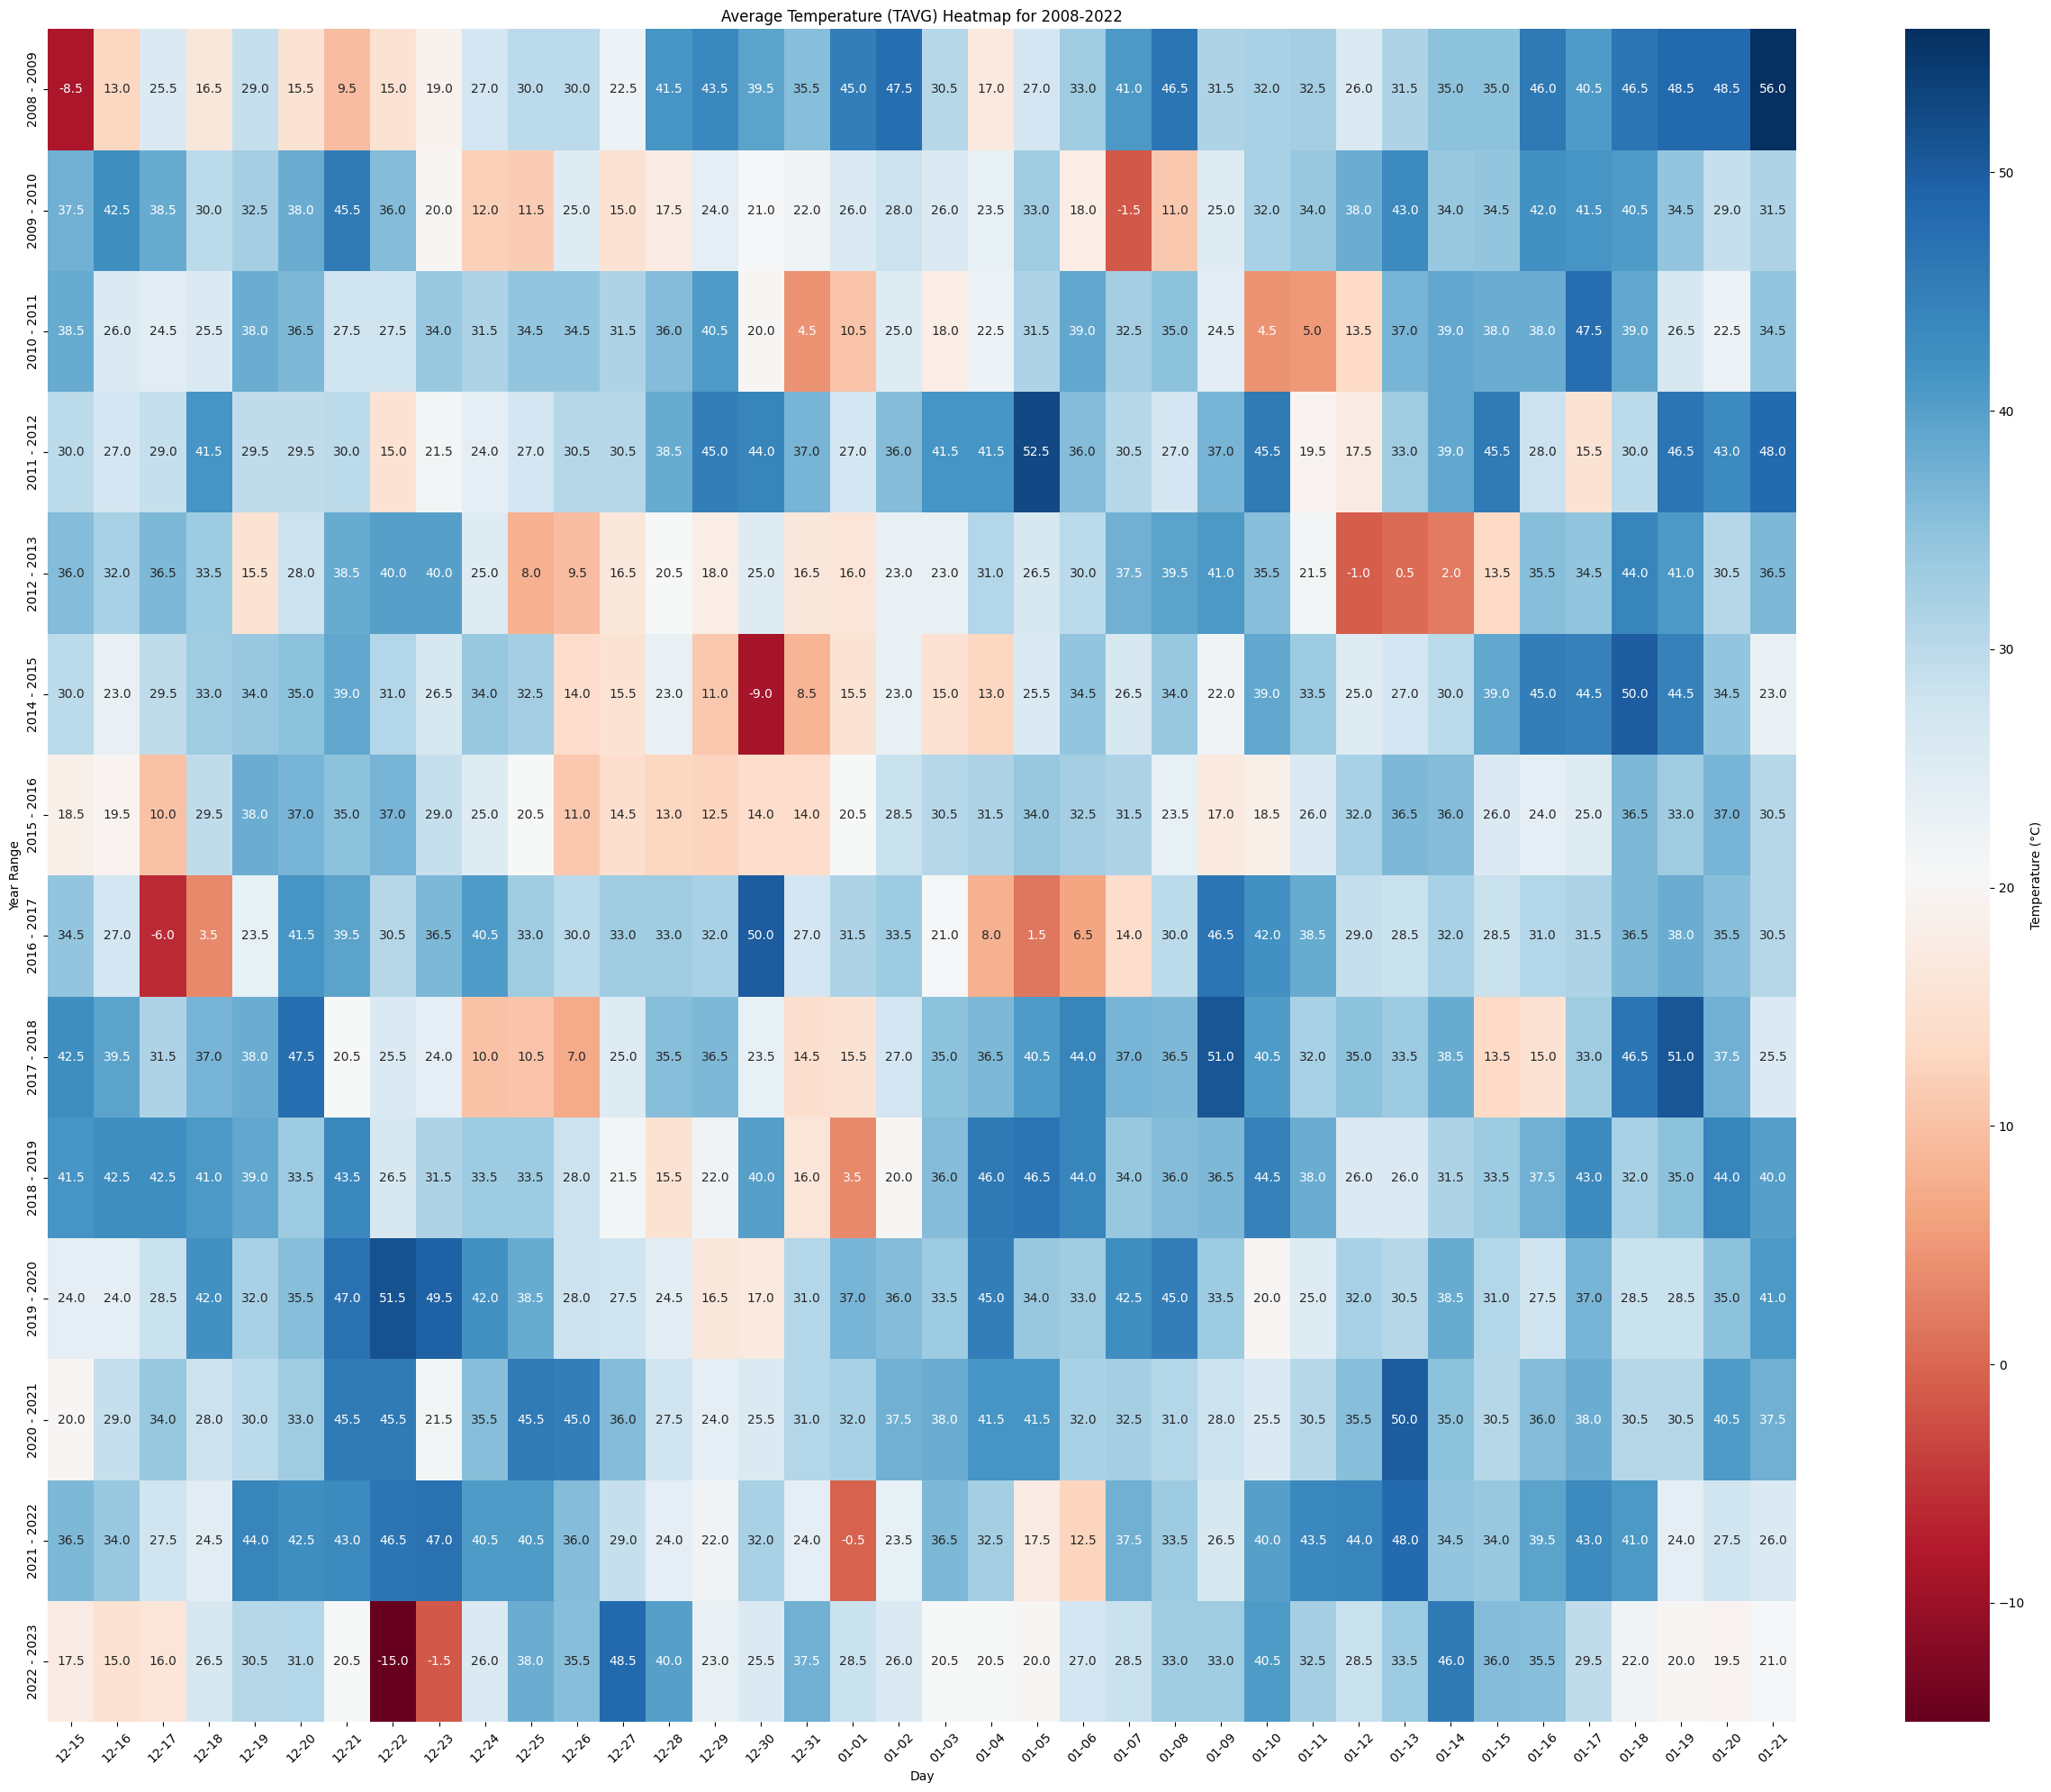

In [9]:
# Transpose the dataframe to have years as rows and days as columns
denver_airport_weather_data = denver_airport_weather_data.set_index('Date').T

# Create the heatmap
plt.figure(figsize=(25, 20))
sns.heatmap(denver_airport_weather_data, cmap='RdBu', cbar_kws={'label': 'Temperature (°C)'}, annot=True, fmt=".1f")
plt.title('Average Temperature (TAVG) Heatmap for 2008-2022')
plt.xlabel('Day')
plt.ylabel('Year Range')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()